In [32]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Download stock data from Yahoo Finance
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']
spread = hmc_data - hymtf_data

# Split data into training and testing sets
train_end = (datetime.now() - relativedelta(years=5))
spread_train = spread.loc[:train_end]
spread_test = spread.loc[train_end:]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


# Data Analysis

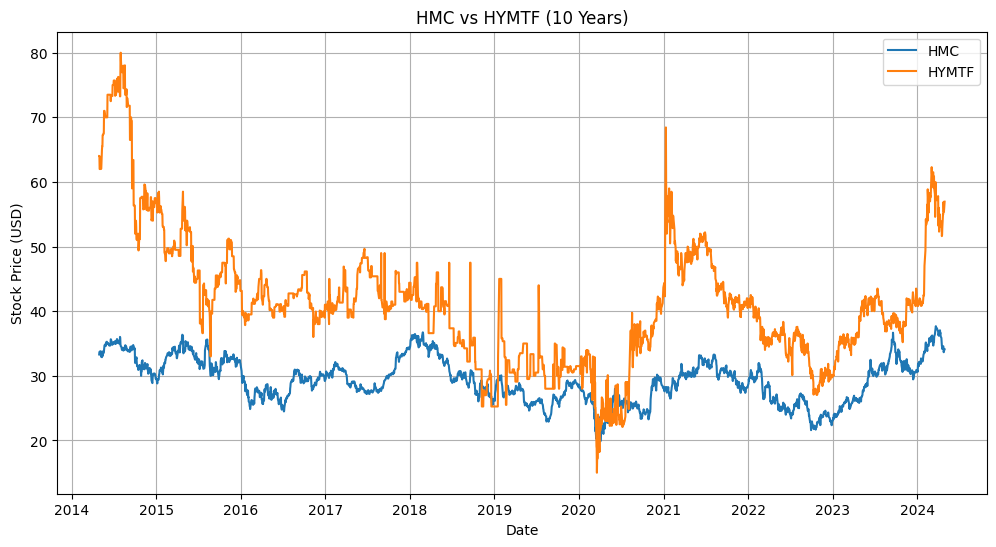

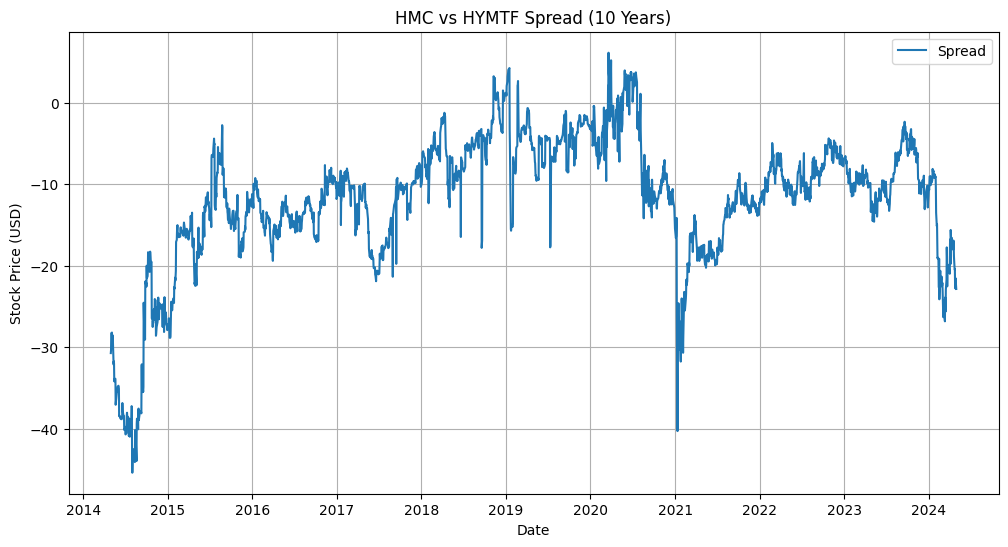

In [33]:
import matplotlib.pyplot as plt

# Plot the 'Close' data:
plt.figure(figsize=(12, 6))
plt.plot(hmc_data, label='HMC')
plt.plot(hymtf_data, label='HYMTF')
plt.title('HMC vs HYMTF (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the spread data:
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread')
plt.title('HMC vs HYMTF Spread (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## ARMA Model Analysis

Plotting the ACF and PACF functions help determine the optimal orders for the AR and MA regressions respectively. What you should see is the data taking a sharp cutoff into the blue area of the graphs. The value at which this cutoff occurs suggests it is an optimal order for that portion of the model.

In the case of these 2 stocks, the ACF does not contain this sharp cutoff. This suggests that there is some additional variable that is also correlted to the value of the spread. Therefore, we should move forward with an ARIMA model instead to try and account for this additional variable.



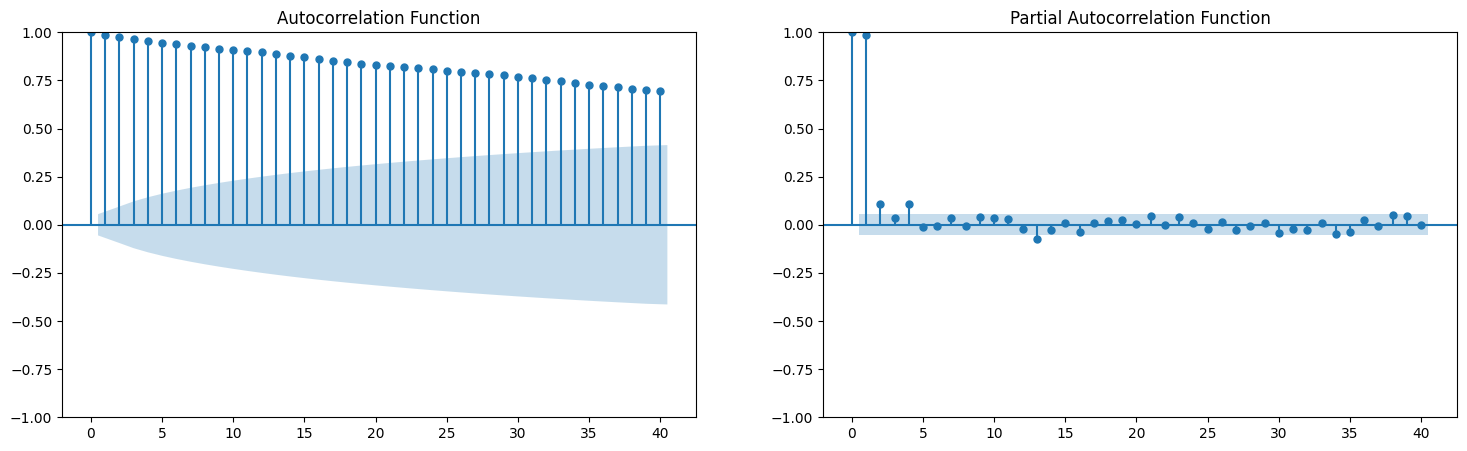

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(spread_series: pd.Series, lags=40) -> None:
    """
    Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    to help determine the order of AR and MA components in an ARMA model.

    Args:
    spread_series (pd.Series): The time series data of the spread between two stocks.
    lags (int): Number of lags to include in the plot.

    Returns:
    None: Displays the ACF and PACF plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Plot ACF
    plot_acf(spread_series, ax=axes[0], lags=lags)
    axes[0].set_title('Autocorrelation Function')

    # Plot PACF
    plot_pacf(spread_series, ax=axes[1], lags=lags)
    axes[1].set_title('Partial Autocorrelation Function')

    plt.show()

plot_acf_pacf(spread_train, lags=40)

## ARIMA Model

The Arima model is just like ARMA, except with an additional feature to regress against. its optimal orders can be determined using the auto_arima function rather than plotting since we have already confirmed that ARMA was unsatisfactory.

In [35]:
from pmdarima import auto_arima, ARIMA

def determine_arima_order(spread_series: pd.Series, seasonal=False, information_criterion='aic', trace=True) -> ARIMA:
    """
    Determines the optimal ARIMA order for a given time series.

    Parameters:
    spread_series (array-like): The time series data.
    seasonal (bool, optional): Whether the time series has a seasonal component. Default is False.
    information_criterion (str, optional): The information criterion used to select the best model. Default is 'aic'.

    Returns:
    best_fit (ARIMA model): The best-fit ARIMA model based on the selected order.

    """
    best_fit = auto_arima(spread_series, seasonal=seasonal, stepwise=True, trace=trace,
                          error_action='ignore', suppress_warnings=True, 
                          information_criterion=information_criterion)
    return best_fit

best_fit = determine_arima_order(spread_train)  # Determine the optimal ARIMA order
print(best_fit)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4596.048, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4629.483, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4610.528, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4608.501, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4627.701, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4596.975, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4597.530, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4596.908, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4594.790, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4592.842, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4591.499, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4607.298, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4592.913, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4594.835, Time=0.52 sec
 ARIMA(0,1,3)(0,0,0)[0]          

In [36]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResultsWrapper
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import pandas as pd
from matplotlib.figure import Figure
from typing import Tuple
import warnings


def fit_arima_model(spread_series: pd.Series, order: Tuple[int, int, int], hide_warnings=True) -> ARIMAResultsWrapper:
    """
    Fit an ARIMA model to the provided time series data.

    Args:
    spread_series (pd.Series): The time series data of the spread between two stocks.
    order (tuple): The order (p, d, q) of the ARMA model.
    hide_warnings (bool): If True, suppress warnings from the ARIMA model.

    Returns:
    model_fit (ARIMAResultsWrapper): The fitted ARIMA model.
    """
    # Fit the ARIMA model
    if hide_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = ARIMA(spread_series, order=(order[0], order[1], order[2]))
            model_fit = model.fit()
    else:
        model = ARIMA(spread_series, order=(order[0], order[1], order[2]))
        model_fit = model.fit()
    
    return model_fit

def model_diagnostics(model_fit: ARIMAResultsWrapper, spread_testing=False, spread_actual=None, hide_warnings=True) -> Figure:
    """
    Perform diagnostics on the fitted model to check for any issues.

    Args:
    model_fit (ARIMAResultsWrapper): The fitted ARIMA model.
    spread_testing (bool): If True, perform testing on the spread.
    spread_testing_data (pd.Series): The testing data for the spread. Required if spread_testing is True.
    hide_warnings (bool): If True, suppress warnings from the ARIMA model.

    Returns:
    fig (Figure): Matplotlib figure object containing the diagnostics plots.
    """
    if spread_testing:
        if spread_actual is None:
            raise ValueError("spread_actual must be provided if spread_testing is True")
        predictions = forecast_spread(model_fit, steps=len(spread_actual), hide_warnings=hide_warnings)['mean']
        mse = root_mean_squared_error(spread_actual, predictions)
        mape = mean_absolute_percentage_error(spread_actual, predictions)
        print(f'Mean Squared Error: {mse:.2f}') 
        print(f'Mean Absolute Percentage Error: {mape:.2f}%')
    
    if hide_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            fig = model_fit.plot_diagnostics(figsize=(12, 8))
    else:
        fig = model_fit.plot_diagnostics(figsize=(12, 8))
    plt.show()
    
    return fig

def forecast_spread(model_fit: ARIMAResultsWrapper, steps=5, hide_warnings=True) -> pd.DataFrame:
    """
    Forecast future values of the spread using the fitted ARIMA model.

    Args:
    model_fit (ARIMAResultsWrapper): The fitted ARMA model.
    steps (int): Number of future steps to forecast.

    Returns:
    forecast_result (pd.DataFrame): The forecasted values along with confidence intervals.
    """
    if hide_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            forecast_result = model_fit.get_forecast(steps=steps)
            forecast_df = forecast_result.summary_frame()
    else:
        forecast_result = model_fit.get_forecast(steps=steps)
        forecast_df = forecast_result.summary_frame()
    
    return forecast_df


## Spread Prediction Metrics

### Root Mean Squared Error
- Use to Mesaure the absolute accuracy of the models predictions
### Mean Absolute Precentage Error
- Use to compare the prediction accuracies on different spread data

## Model Diagnostics

### Standardized Residuals Over Time

This plot shows the residuals of the model over time. In a well-behaved model, we would expect the residuals to be randomly scattered around zero.

### Histogram plus Estimated Density

- This plot shows a histogram of the residuals along with the estimated density of the residuals.

- The orange line is the standard normal density

- Useful for checking if the residuals are normally distributed, which is one of the assumptions of an ARIMA model.

### Normal Q-Q Plot

Another way of checking if the residuals are normally distributed. If the residuals are normally distributed, the points in the Q-Q plot should lie along the red line.

### Correlelogram

- Shows the autocorrelation of the residuals. 

- In a well-behaved model, we would expect that there is little to no correlation between the residuals. 

- This means that the points in the correlogram should fall inside the blue area.




Mean Squared Error: 7.43
Mean Absolute Percentage Error: 1.00%


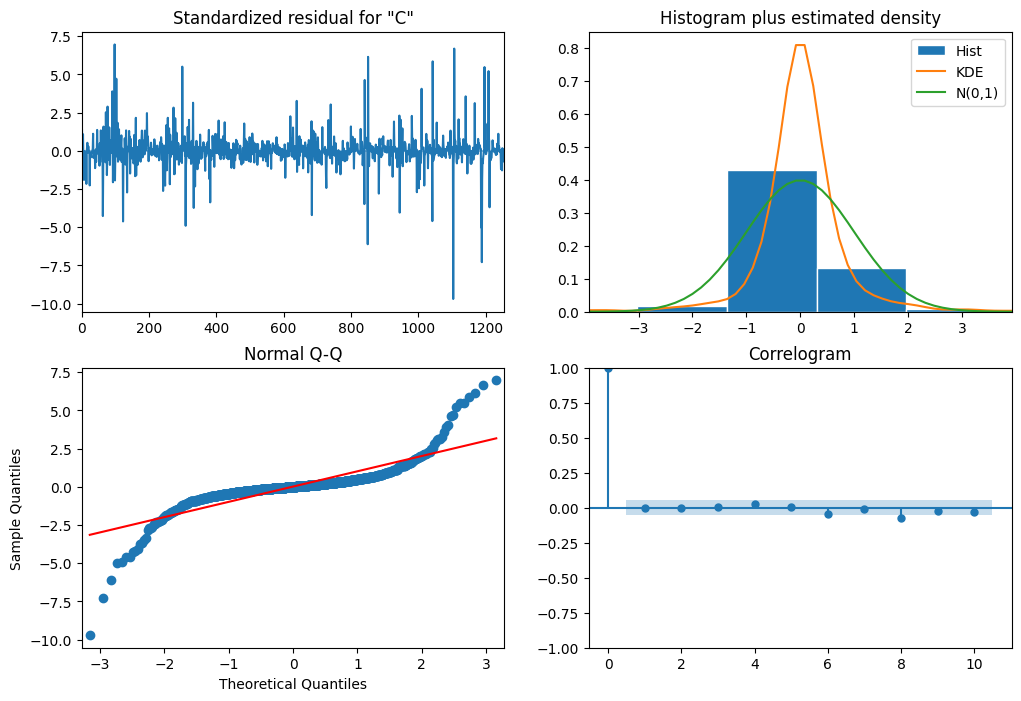

In [37]:
# Example usage of the functions defined above
model_fit = fit_arima_model(spread_train, best_fit.order)   # Fit the ARIMA model
diagnostics_fig = model_diagnostics(model_fit, spread_testing=True, spread_actual=spread_test)  # Perform and show diagnostics on the fitted model
forecast_df = forecast_spread(model_fit, steps=10)  # Forecast future values of the spread
forecast_df.to_csv('forecast.csv')  # Save the forecasted values to a CSV file

# Backtesting

In [38]:
import yfinance as yf
import pandas as pd

# Download HMC and MYMTF price data:
hmc_data: pd.Series = yf.download('HMC', period='10y')['Close']
hymtf_data: pd.Series = yf.download('HYMTF', period='10y')['Close']
# Calculate the spread:
spread: pd.Series = hymtf_data - hmc_data

ROLLING_WINDOW = 16     # This is used for determining how many days ahead to use to calculate the rolling mean
TRAINING_PERIOD = 600   # This is the number of days to use for the training period
MONEY_PER_TRADE = 50000 # Capital to allocate to each trade in the pairs trade

# Convert capital to shares:
hmc_share_quant = MONEY_PER_TRADE/hmc_data
hymtf_share_quant = MONEY_PER_TRADE/hymtf_data

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


## How Forecastasts are Being Used

Currently I fit an ARIMA model to the data based on a specified training window. Then, I use this model to forecast future values of the spread beginning at the current date. 

Then, I take the rolling mean with a size of ROLLING_WINDOW, and I extract the first observation from this series.

Ditto with the standard deviation.

I use the pulled mean and and standard deviation to calculate bollinger bands then check for arbitrage oppurtunities. 

Additionally, I retrain the model in intervals of TRAINING_PERIOD

In [39]:
import pandas as pd

daily_returns = []
trade_log = []
position_open = False
position_type = None
best_fit = determine_arima_order(spread.iloc[:TRAINING_PERIOD], trace=False)
model_fit = fit_arima_model(spread.iloc[:TRAINING_PERIOD], best_fit.order)

for date, current_spread in spread.items():
    if date not in hmc_data.index or date < spread.index[TRAINING_PERIOD]:
        continue

    reg_index = spread.index.get_loc(date)
    if reg_index % TRAINING_PERIOD == 0:
        # Retrain the ARIMA model every TRAINING_PERIOD days
        best_fit = determine_arima_order(spread.iloc[(reg_index - TRAINING_PERIOD):reg_index], trace=False)
        model_fit = fit_arima_model(spread.iloc[(reg_index - TRAINING_PERIOD):reg_index], best_fit.order)

    
    # Forecast the spread for the next ROLLING_WINDOW days
    forecast_df = forecast_spread(model_fit, steps=ROLLING_WINDOW)
    # Calculate the rolling mean and bands bbased on foredasted spread
    rolling_mean = forecast_df['mean'].rolling(window=ROLLING_WINDOW).mean().dropna()
    rolling_std = forecast_df['mean'].rolling(window=ROLLING_WINDOW).std().dropna()
    upper_band = rolling_mean + (rolling_std * 0.8)
    lower_band = rolling_mean - (rolling_std * 0.8)

    upper_band_value = upper_band.iloc[0]
    lower_band_value = lower_band.iloc[0]
    mean_value = rolling_mean.iloc[0]
    hmc_price = hmc_data.get(date, None)
    hymtf_price = hymtf_data.get(date, None)
    hmc_shares = hmc_share_quant.get(date, None)
    hymtf_shares = hymtf_share_quant.get(date, None)
    if current_spread < lower_band_value and not position_open:
        # Open a pairs trade position (short HMC, long HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'lower'
        
    elif current_spread > upper_band_value and not position_open:
        # Open a different pairs trade position (long HMC, short HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'upper'
    
    elif current_spread > mean_value and position_open and position_type == 'lower':
        # Close position opened at lower band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False
        
    elif current_spread < mean_value and position_open and position_type == 'upper':
        # Close position opened at upper band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False

# Save the trade log DataFrame to a csv file for a visual sanity check:
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

In [40]:
import pandas as pd

# Iterate through rows in our trade log DataFrame and calcule the pnl:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []
for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'lower':
            hmc_profit_loss = (open_position['HMC_Price'] - trade['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (trade['HYMTF_Price'] - open_position['HYMTF_Price']) * (open_position['HYMTF_Shares'])
        elif open_position['Type'] == 'upper':
            hmc_profit_loss = (trade['HMC_Price'] - open_position['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (open_position['HYMTF_Price'] - trade['HYMTF_Price']) * (open_position['HYMTF_Shares'])

        total_profit_loss = hmc_profit_loss + hymtf_profit_loss
        total_return += total_profit_loss
        close_position_returns.append(total_profit_loss)

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

# Backtest Analysis

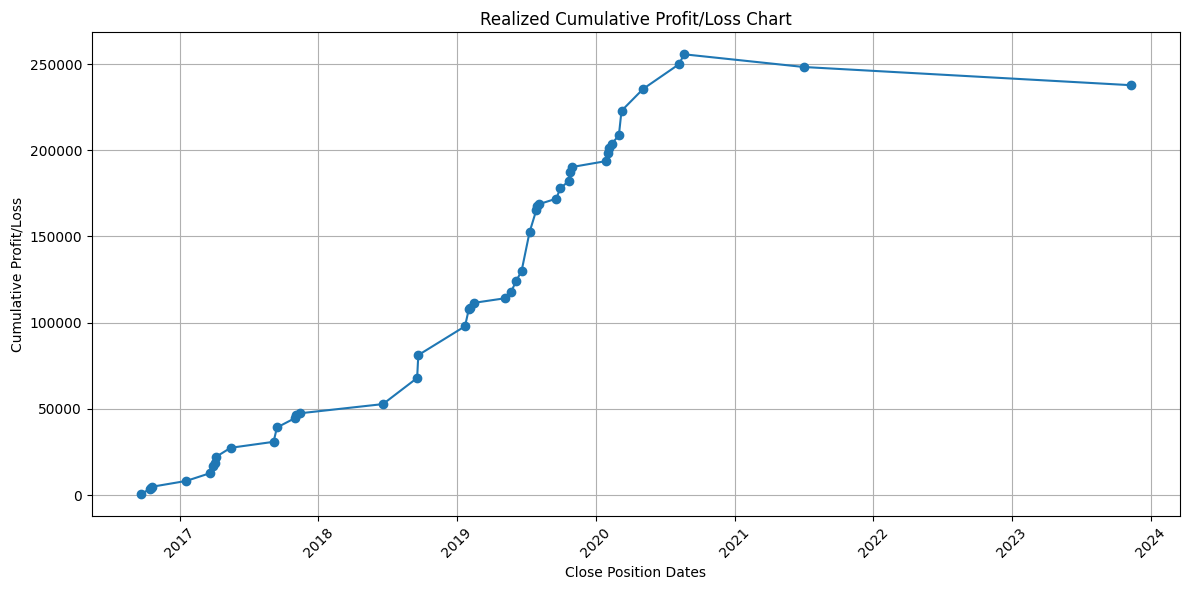

In [41]:
import matplotlib.pyplot as plt

# Calculate the cumulative profit and loss:
profit_loss_df['Cumulative PnL'] = profit_loss_df['Profit/Loss'].cumsum()

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(profit_loss_df.index, profit_loss_df['Cumulative PnL'], marker='o', linestyle='-')
plt.title('Realized Cumulative Profit/Loss Chart')
plt.xlabel('Close Position Dates')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Annual Sharpe Ratio:
 Year
2016    1.344894
2017    7.850571
2018    2.447330
2019    7.109656
2020    5.026509
2021         NaN
2023         NaN
Name: Returns, dtype: float64

Number of Trades per Year:
 Year
2016     4
2017    11
2018     3
2019    17
2020     9
2021     1
2023     1
dtype: int64

Average Sharpe Ratio: 4.755792198317412


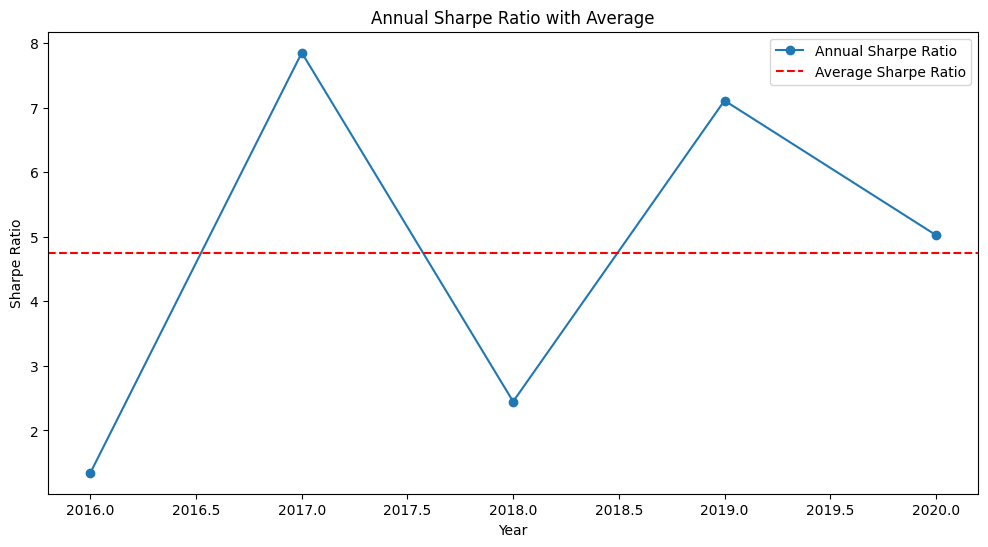

In [42]:
# Import the packages needed for this task:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert the PnL to returns:
capital = 100000  # Adjust this as per your initial capital
profit_loss_df['Returns'] = profit_loss_df['Profit/Loss'] / capital

# Group the data by year using the index:
profit_loss_df['Year'] = profit_loss_df.index.year

# Count the trades per year and calculate the average:
trades_per_year = profit_loss_df.groupby('Year').size()
average_trades_per_year = trades_per_year.mean()

# Calculate the annual return as well as the standard deviation:
annual_returns = profit_loss_df.groupby('Year')['Returns'].sum()
annual_std_dev = profit_loss_df.groupby('Year')['Returns'].std() * np.sqrt(average_trades_per_year)
annual_risk_free_rate = 0.01

# Calculate the annual Sharpe Ratio:
annual_sharpe_ratio = (annual_returns - annual_risk_free_rate) / annual_std_dev

# Calculate the average Sharpe Ratio:
average_sharpe_ratio = annual_sharpe_ratio.mean()


# Print info:
print("Annual Sharpe Ratio:\n", annual_sharpe_ratio)
print("\nNumber of Trades per Year:\n", trades_per_year)
print("\nAverage Sharpe Ratio:", average_sharpe_ratio)

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(annual_sharpe_ratio, label='Annual Sharpe Ratio', marker='o')
plt.axhline(y=average_sharpe_ratio, color='r', linestyle='--', label='Average Sharpe Ratio')
plt.title('Annual Sharpe Ratio with Average')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()